# **Harris Corner Detector**

Implement a baisc Harris Corner Detector from scratch

refs:
- https://www.cs.umd.edu/class/fall2019/cmsc426-0201/files/12_HarrisCornerDetection.pdf
- https://www.cs.cmu.edu/~16385/s17/Slides/6.2_Harris_Corner_Detector.pdf
- http://www.bmva.org/bmvc/1988/avc-88-023.pdf


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

## Get Test Images

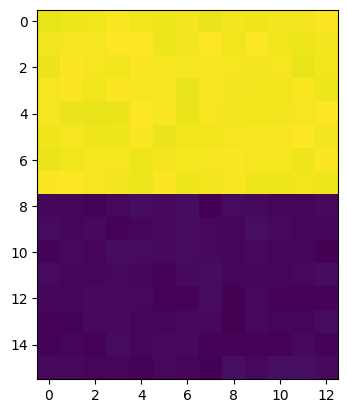

In [62]:
square_sz = 25
awgn = lambda x = square_sz: np.random.normal(loc=0.0, scale=1.0, size=(x,x))
square = np.ones((square_sz, square_sz), dtype=np.float64)

test_image = np.block([[square*100 + awgn(), square*0 + awgn()], 
                       [square*0 + awgn(), square*0 + awgn()]])

flat = test_image[square_sz//2:square_sz, square_sz//2:square_sz]
corner = test_image[square_sz-10:square_sz+8, square_sz-10:square_sz+8]
h_edge = test_image[square_sz-8:square_sz+8, square_sz//2:square_sz]
v_edge = test_image[square_sz//2:square_sz, square_sz-8:square_sz+8]

plt.imshow(h_edge);

Select test image

In [229]:
from skimage.data import brick

# image = corner.copy()

image = brick().astype(np.float32)

# 0-1 normalize
image /= image.max()

Compute x and y derivatives

In [232]:
Sx = np.array([[1, 0, -1],
               [2, 0, -2],
               [1, 0, -1]])

Sy = Sx.T

Ix = cv2.filter2D(image, ddepth=-1, kernel=Sx)
Iy = cv2.filter2D(image, ddepth=-1, kernel=Sy)

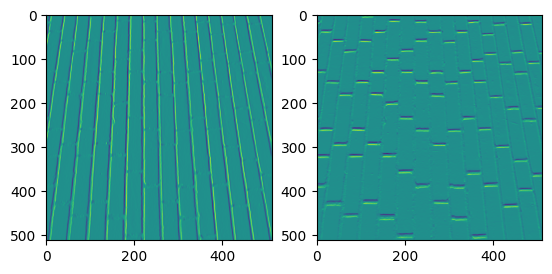

In [233]:
_, ax = plt.subplots(1, 2)
ax[0].imshow(Ix);
ax[1].imshow(Iy);

In [234]:
A = Ix @ Ix.T
B = Iy @ Iy.T
C = Ix @ Iy.T

A = Ix @ Ix
B = Iy @ Iy
C = Ix @ Iy

# A = Ix * Ix
# B = Iy * Iy
# C = Ix * Iy

In [235]:
# Gaussian Kernel
G = np.array([
    [1/16, 2/16, 1/16],
    [2/16, 4/16, 2/16],
    [1/16, 2/16, 1/16]])

In [236]:
# construct M matrix block
A = cv2.filter2D(Ix @ Ix, ddepth=-1, kernel=G)
B = cv2.filter2D(Iy @ Iy, ddepth=-1, kernel=G)
C = cv2.filter2D(Ix @ Iy, ddepth=-1, kernel=G)

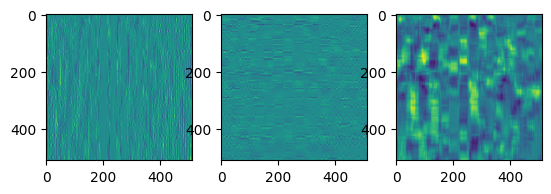

In [237]:
_, ax = plt.subplots(1, 3)
ax[0].imshow(A)
ax[1].imshow(B)
ax[2].imshow(C);

In [238]:
k = 0.005

tr_m = A + B
det_m = A@B - (C@C)

R = det_m - k*(tr_m@tr_m)

In [240]:
R

array([[-218.57237, -197.52441, -210.12073, ..., -511.9318 , -353.71994,
        -267.50842],
       [-123.72728, -101.07816, -112.14616, ..., -544.6042 , -388.3714 ,
        -303.85748],
       [  78.78244,  101.89773,   89.71276, ..., -606.9914 , -462.06375,
        -383.8208 ],
       ...,
       [1656.3633 , 1731.1616 , 1858.2532 , ...,  257.82047,  162.02489,
          78.36323],
       [1645.8282 , 1720.1215 , 1845.4652 , ...,  259.463  ,  161.81737,
          76.20377],
       [1637.5419 , 1711.2205 , 1835.0565 , ...,  260.91708,  162.52669,
          76.31019]], dtype=float32)

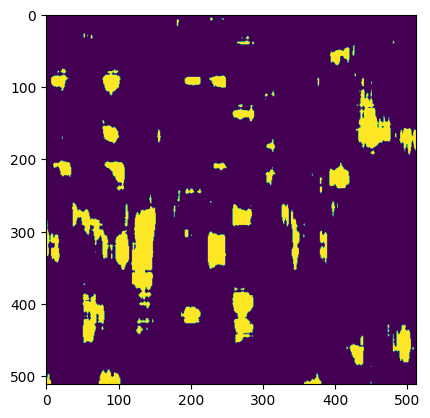

In [244]:
plt.imshow(R > 1500)

In [245]:
def get_win(dx, dy, x, y):
    Ix = []
    Iy = []
    # default window size is 3
    x1 = x - 1
    x2 = x + 1
    y1 = y - 1
    y2 = y + 1
    for u in [-1, 0, 1]:
        for v in [-1, 0, 1]:
            Ix.append(dx[y1+v:y2+v, x1+u:x2+u])
            Iy.append(dy[y1+v:y2+v, x1+u:x2+u])
    
    Ix = np.dstack(Ix).sum(axis=-1)
    Iy = np.dstack(Iy).sum(axis=-1)

    return Ix, Iy


def get_win_2(dx, dy, dxy, x, y):
    Ix = []
    Iy = []
    Ixy = []
    # default window size is 3
    x1 = x - 1
    x2 = x + 1
    y1 = y - 1
    y2 = y + 1
    for u in [-1, 0, 1]:
        for v in [-1, 0, 1]:
            Ix.append(dx[y1+v:y2+v, x1+u:x2+u])
            Iy.append(dy[y1+v:y2+v, x1+u:x2+u])
            Ixy.append(dxy[y1+v:y2+v, x1+u:x2+u])
    
    Ix = np.dstack(Ix).sum(axis=-1)
    Iy = np.dstack(Iy).sum(axis=-1)
    Ixy = np.dstack(Ixy).sum(axis=-1)

    return Ix, Iy, Ixy

In [246]:
x,y

(15, 15)

In [261]:
k = 0.005
image2 = np.dstack((image, image, image))
R_mats = []
for x in range(2, image.shape[0] - 2):
    for y in range(2, image.shape[1] - 2):
        _Ix, _Iy = get_win(Ix, Iy, x, y)

        Ixx = _Ix @ _Ix
        Iyy = _Iy @ _Iy
        Ixy = _Ix @ _Iy

        _A = cv2.filter2D(Ixx, ddepth=-1, kernel=G)
        _B = cv2.filter2D(Iyy, ddepth=-1, kernel=G)
        _C = cv2.filter2D(Ixy, ddepth=-1, kernel=G)

        tr_m = _A + _B
        det_m = _A@_B - (_C@_C)

        R_mats.append(det_m - k*(tr_m@tr_m))
        if R_mats[-1].max() > 500:
            print(x, y, R_mats[-1].max())
            cv2.circle(image2, center=(x, y), radius=3, color=(0,225,0),thickness=-1)

37 57 531.12823
64 81 731.74994
65 81 610.8527
66 299 522.08966
90 151 555.60785
99 58 500.978
104 2 549.58374
108 265 513.7176
116 295 828.025
117 295 532.38043
121 64 632.86426
122 64 981.15173
125 127 520.75916
125 128 866.7509
132 38 534.6137
133 41 1036.2848
136 291 537.38416
136 292 884.6685
147 185 592.39166
149 315 684.7442
150 135 928.19574
151 135 615.5561
159 99 527.3596
174 467 541.21216
182 206 1109.0148
183 206 701.98615
185 353 625.9332
186 18 544.3531
186 353 727.1594
187 14 503.16537
187 18 669.9801
193 79 559.1885
216 85 500.4652
216 239 605.9021
223 14 618.98334
224 149 572.74866
224 150 531.1938
260 133 966.87915
290 299 522.2339
297 430 532.5486
311 66 677.10425
340 43 518.09454
343 15 501.75906
352 102 770.4981


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


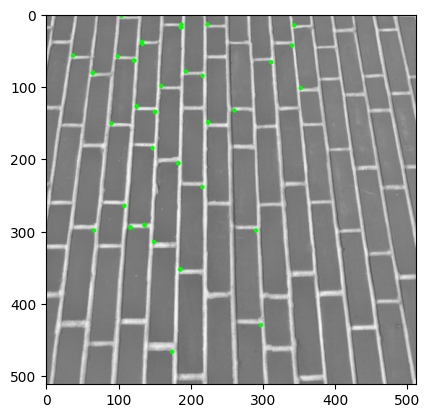

In [262]:
plt.imshow(image2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


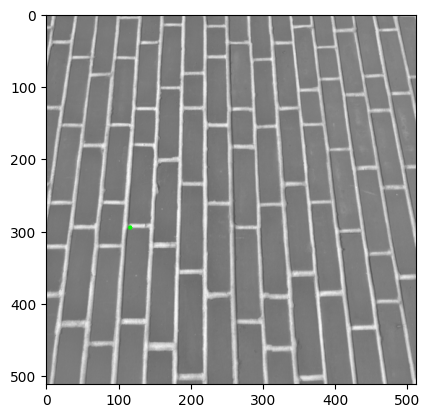

In [258]:
image2 = np.dstack((image, image, image))
cv2.circle(image2, center=(116, 295), radius=3, color=(0,225,0),thickness=-1)
# cv2.circle(image2, center=(295, 116), radius=3, color=(0,225,0),thickness=-1)
# cv2.circle(image2, center=(122, 64), radius=3, color=(255,225,0),thickness=-1)
# cv2.circle(image2, center=(125, 128), radius=3, color=(255,0,0),thickness=-1)
# cv2.circle(image2, center=(133, 41), radius=3, color=(0,225,0),thickness=-1)
# cv2.circle(image2, center=(136, 292), radius=3, color=(255,225,0),thickness=-1)
# cv2.circle(image2, center=(150, 135), radius=3, color=(255,0,0),thickness=-1)
# cv2.circle(image2, center=(182, 206), radius=3, color=(255,225,0),thickness=-1)
# cv2.circle(image2, center=(260, 133), radius=3, color=(255,0,0),thickness=-1)
plt.imshow(image2)

In [263]:
k = 0.005
image3 = np.dstack((image, image, image))
R_mats = []
for x in range(2, image.shape[0] - 2):
    for y in range(2, image.shape[1] - 2):
        _A, _B, _C = get_win_2(A, B, C, x, y)

        tr_m = _A + _B
        det_m = _A@_B - (_C@_C)

        R_mats.append(det_m - k*(tr_m@tr_m))
        if R_mats[-1].max() > 500:
            print(x, y, R_mats[-1].max())
            cv2.circle(image3, center=(x, y), radius=3, color=(0,225,0),thickness=-1)

2 132 865.3906
2 133 1747.8157
2 134 1496.1532
2 135 737.6085
3 37 561.8722
3 38 643.2467
3 132 811.73474
3 133 1812.2086
3 134 1699.7484
3 135 946.6653
4 37 909.2283
4 38 1344.204
4 39 1021.08875
4 133 800.60486
4 134 1006.1762
4 135 697.26685
4 391 707.7736
4 392 826.56494
4 393 740.3118
5 37 638.25867
5 38 1215.5702
5 39 1127.0685
5 128 802.61255
5 129 1020.73615
5 130 621.3271
5 391 755.95215
5 392 1035.4993
5 393 1044.0172
5 394 726.16125
6 39 611.5303
6 128 1437.4485
6 129 2192.92
6 130 1840.4489
6 260 575.9549
6 392 599.0645
6 393 729.0906
6 394 542.31195
7 128 947.7848
7 129 1818.4298
7 130 1833.1901
7 131 751.28094
7 155 738.5631
7 156 611.056
7 504 604.12213
7 505 596.9404
8 129 654.31433
8 130 878.5192
8 131 506.5164
8 155 652.56036
8 156 760.4311
8 263 502.61447
10 131 784.416
10 132 949.86346
11 131 1295.2108
11 132 2268.505
11 133 1607.3826
11 436 537.326
12 131 1080.2871
12 132 2656.0894
12 133 2735.1458
12 134 1413.3127
12 436 768.2267
12 437 721.67505
13 132 1849.1146


In [ ]:
plt.imshow(image3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


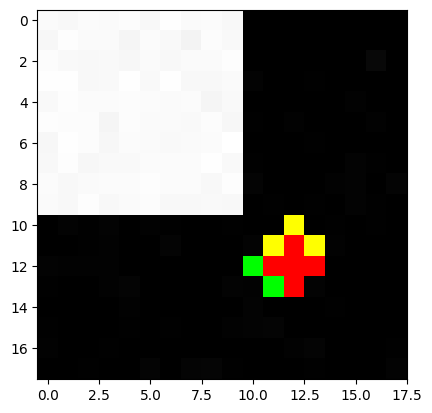

In [218]:
image2 = np.dstack((image, image, image))
cv2.circle(image2, center=(11, 12), radius=1, color=(0,225,0),thickness=-1)
cv2.circle(image2, center=(12, 11), radius=1, color=(255,225,0),thickness=-1)
cv2.circle(image2, center=(12, 12), radius=1, color=(255,0,0),thickness=-1)
plt.imshow(image2)

In [182]:
_A = cv2.filter2D(Ixx, ddepth=-1, kernel=G)
_B = cv2.filter2D(Iyy, ddepth=-1, kernel=G)
_C = cv2.filter2D(Ixy, ddepth=-1, kernel=G)

In [187]:
    k = 0.005

    tr_m = _A + _B
    det_m = _A@_B - (_C@_C)

    R = det_m - k*(tr_m@tr_m)

In [188]:
R

array([[0.0017583, 0.0017583],
       [0.0017583, 0.0017583]])